In [1]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import integrate
import lmfit
from lmfit import minimize, Parameters
from lmfit import Model
from scipy import ndimage

# Constants

In [2]:
h = 6.62*10**-34
hbar = h/(2*np.pi)
kb = 1.38*10**-23
c = 3*10**8
e = 1.602*10**-19
eps_0 = 8.8542*10**-12

wl_1064 = 1064*10**-9
omega_1064 = 2*np.pi*c/wl_1064

wl_D2 = 780.241*10**-9
omega_D2 = 2*np.pi*c/wl_D2
gamma_D2 = 2*np.pi * 6.065*10**6

wl_D1 = 794.978*10**-9
omega_D1 = 2*np.pi*c/wl_D1
gamma_D1 = 2*np.pi * 5.746*10**6

omega_avg = (omega_D2+omega_D1)/2

detuning_D1 = omega_1064 - omega_D1
detuning_D2 = omega_1064 - omega_D2
detuning_avg = omega_1064 - (omega_D1+omega_D2)/2

me = 9.109*10**-31
mRb = 85.4678*1.6605*10**-27
alpha = 1/137

def trap_freq(waist, power): #waist in µm, power in W, returns freq in kHz   
    w = waist
    P = power
    return (1/(2*np.pi))*(4/omega_1064)*np.sqrt((alpha*hbar)/(me*mRb))*(np.sqrt(P)/w**2)*10**-3  

print((alpha*h/(kb*me*omega_1064**2))*2*5.3/(np.exp(1)*np.pi*(33.2*10**-6)**2)*10**6)

137.92849162642474


In [3]:
def LG(r, waist, power):     #waist = 4*sigma
    return power*(4/np.pi)*(r**2/waist**4)*np.exp(-2*r**2/waist**2)

def gaussian(r, waist, power):     #waist = 4*sigma
    return power*2/(np.pi*waist**2)*np.exp(-2*r**2/waist**2)

def convolution(r, waist_LG, waist_blue, power_LG, power_blue):
    conv = lambda x: LG(r-x, waist_LG, power_LG)*gaussian(x, waist_blue, power_blue)
    return scipy.integrate.quad(conv, -np.inf , np.inf)[0]
    

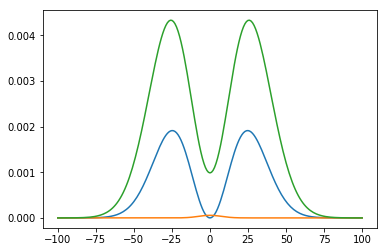

In [4]:
x_range = np.linspace(-100, 100, 201)

waist_LG = 35
waist_blue = 15
power_LG = 10
power_blue = 0.02

plt.figure()
plt.plot(x_range, LG(x_range, waist_LG, power_LG))
plt.plot(x_range, gaussian(x_range, waist_blue, power_blue))

res = np.zeros(201)
for i in range(201):
    res[i] = convolution(x_range[i], waist_LG, waist_blue, power_LG, power_blue)

plt.plot(x_range, 2500*res)

# Power and waist estimation

In [5]:
#distance between the two peaks :

D = (45)   #µm

w = D*10**-6/np.sqrt(2)    #estimation of the waist

print('Estimated waist : '+ str(np.round(w*10**6,3)) + ' (µm)')

Estimated waist : 31.82 (µm)


In [9]:
coeff_GS = ((np.pi*c**2)/(2*h*omega_avg**3))*(gamma_D1/detuning_D1 + 2*gamma_D2/detuning_D2)    #in Hz
coeff_Ryd = (e**2)/(2*me*eps_0*c*(omega_1064)**2)/(h)                                             #in Hz
print(coeff_GS*10**3)
print(coeff_Ryd*10**3)
print(coeff_Ryd*10**3 - coeff_GS*10**3 )

#Measured lightshift (with gaussian beam)

ls_volt = 2.54  #in V
ls_freq = ls_volt*7.458*10**6
print('Estimated lightshift : '+ str(np.round(ls_freq*10**-6,2)) + ' (MHz)')

exp_power = ls_freq*(np.pi*w**2)/(2*(-coeff_GS + coeff_Ryd))    #for LG beam here, remove e for gaussian
print('Estimated power in the cryo : ' + str(np.round(exp_power,2)) + 'W')
print('')
print('Estimated trapping frequency : ' + str(np.round(trap_freq(w, exp_power),2)) + 'kHz' )


-2.780319707358088
2.5525647277000925
5.3328844350581806
Estimated lightshift : 18.94 (MHz)
Estimated power in the cryo : 5.65W

Estimated trapping frequency : 2.06kHz


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


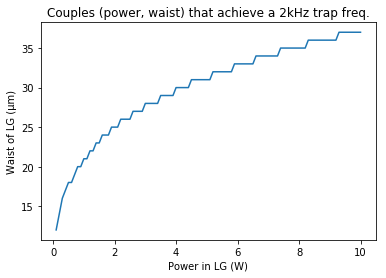

In [45]:
res = np.zeros((100, 2))

for i in range(100):
    res[i,0] = i/10 +0.1
    
for i in range(100):
    
    dist = 1000
    for w in range(100):
        freq = trap_freq(w*10**-6, res[i,0])
        if (np.sqrt((freq-2)**2) < dist):
            res[i,1] = w
            dist = np.sqrt((freq-2)**2)

plt.plot(res[:,0], res[:,1])
plt.xlabel('Power in LG (W)')
plt.ylabel('Waist of LG (µm)')
plt.title('Couples (power, waist) that achieve a 2kHz trap freq.')
plt.savefig('couples2kHz.png', format = 'png', dpi = 1000)